In [2]:
# calculate response time to figure response efficiency

import pandas as pd
import matplotlib.pyplot as plt

df_chats = pd.read_csv('cleaned_data/chats_clean.csv', parse_dates=['created_at', 'updated_at'])
df_chats

,id,client_id,question,answer,created_at,updated_at,bot_id,type,image_url,audio_url,has_image,has_audio
0,1,1,do you recommend traveling to beirut right now?,Traveling to Beirut can be a wonderful experie...,2024-08-19 14:44:14,2024-08-19 14:44:14,0,text,NaN,NaN,0,0
1,2,1,when is the next flight going to italy?,The next flight from Beirut Airport to Italy i...,2024-08-19 14:45:19,2024-08-19 14:45:19,0,text,NaN,NaN,0,0
2,3,1,"hello, tell me more about yourself",Hello! I'm here to assist you with your travel...,2024-08-19 14:52:22,2024-08-19 14:52:22,0,text,NaN,NaN,0,0
3,4,1,hello tell me more about yourself,"Hello! I am your traveler assistant, here to h...",2024-08-19 14:53:10,2024-08-19 14:53:10,0,text,NaN,NaN,0,0
4,5,1,who developed you,I was developed by Ibrahim Fleifel at Xpertbot...,2024-08-19 14:53:28,2024-08-19 14:53:28,0,text,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11016,11344,1,Hi,"Sorry, there was an error processing your requ...",2025-07-10 23:17:52,2025-07-10 23:17:52,2,text,NaN,NaN,0,0
11017,11345,1,How are you?,"Sorry, there was an error processing your requ...",2025-07-10 23:18:08,2025-07-10 23:18:08,2,text,NaN,NaN,0,0
11018,11346,1,Who are u?,"Sorry, there was an error processing your requ...",2025-07-10 23:18:18,2025-07-10 23:18:18,2,text,NaN,NaN,0,0
11019,11347,724,the flights today from spain to lebanon,"Sorry, there was an error processing your requ...",2025-07-12 19:35:12,2025-07-12 19:35:12,2,text,NaN,NaN,0,0


In [7]:
print(df_chats.columns)

Index(['id', 'client_id', 'question', 'answer', 'created_at', 'updated_at',
       'bot_id', 'type', 'image_url', 'audio_url', 'has_image', 'has_audio',
       'response_time', 'question_length', 'answer_length'],
      dtype='object')


In [3]:
# calculate response time
df_chats['response_time'] = (df_chats['updated_at'] - df_chats['created_at']).dt.total_seconds() / 60.0  # in minutes

# drop negateive or null response times
df_chats = df_chats[df_chats['response_time'] >= 0]



In [4]:
# Average length of question/answer per type
df_chats['question_length'] = df_chats['question'].fillna('').str.len()
df_chats['answer_length'] = df_chats['answer'].fillna('').str.len()

avg_lengths = df_chats.groupby('type')[['question_length', 'answer_length']].mean()
print(avg_lengths)


       question_length  answer_length
type                                 
audio        90.813675     645.601709
image       437.798574     781.926916
text         82.385316     572.329316


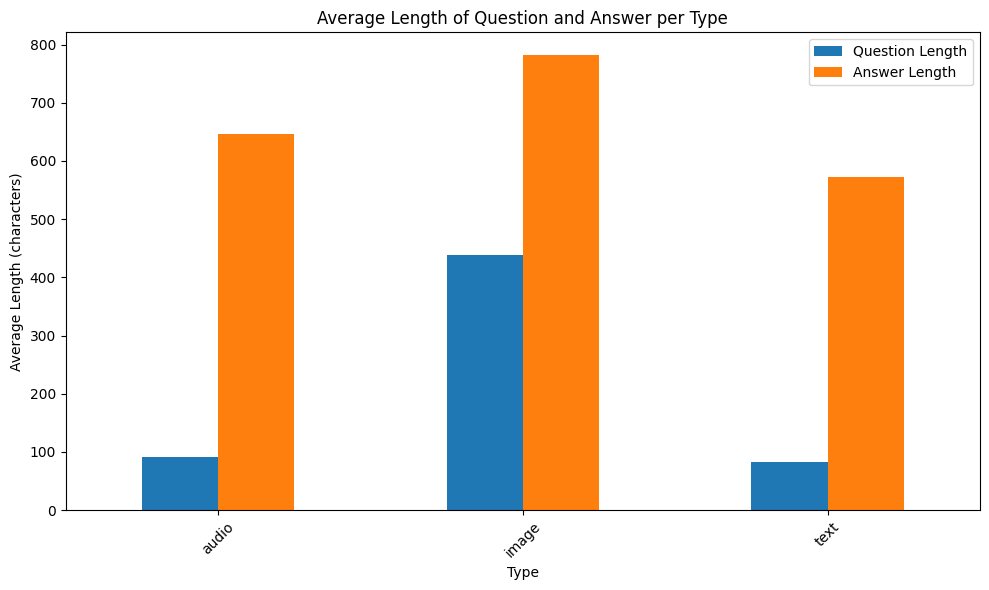

In [5]:
# plot the question and answer lengths per type

avg_lengths.plot(kind='bar', figsize=(10, 6))
plt.title('Average Length of Question and Answer per Type')
plt.xlabel('Type')
plt.ylabel('Average Length (characters)')
plt.xticks(rotation=45)
plt.legend(['Question Length', 'Answer Length'])
plt.tight_layout()
plt.show()

In [8]:
# Turns per conversation = number of Q&A pairs per client
turns_per_client = df_chats.groupby("client_id")["id"].count().reset_index()
turns_per_client.rename(columns={"id": "turns"}, inplace=True)

avg_turns = turns_per_client["turns"].mean()
median_turns = turns_per_client["turns"].median()
max_turns = turns_per_client["turns"].max()

print(f"Average turns per client: {avg_turns:.2f}")
print(f"Median turns per client: {median_turns}")
print(f"Max turns per client: {max_turns}")


Average turns per client: 10.34
Median turns per client: 4.0
Max turns per client: 564


In [10]:
# Convert created_at to datetime
df_chats["created_at"] = pd.to_datetime(df_chats["created_at"])

# Sort chats
df_chats = df_chats.sort_values(["client_id", "created_at"])

# Calculate lag between rows
df_chats["next_msg_time"] = df_chats.groupby("client_id")["created_at"].shift(-1)
df_chats["time_diff"] = (df_chats["next_msg_time"] - df_chats["created_at"]).dt.total_seconds() / 60

# Filter only client → bot pairs (approximation)
response_times = df_chats[df_chats["time_diff"] > 0]["time_diff"]
response_times_clean = response_times[response_times < 30]  # keep under 30 minutes

print("Average response time:", response_times_clean.mean())
print("Median response time:", response_times_clean.median())
print("Max response time:", response_times_clean.max())


Average response time: 1.492535575679172
Median response time: 0.48333333333333334
Max response time: 29.916666666666668


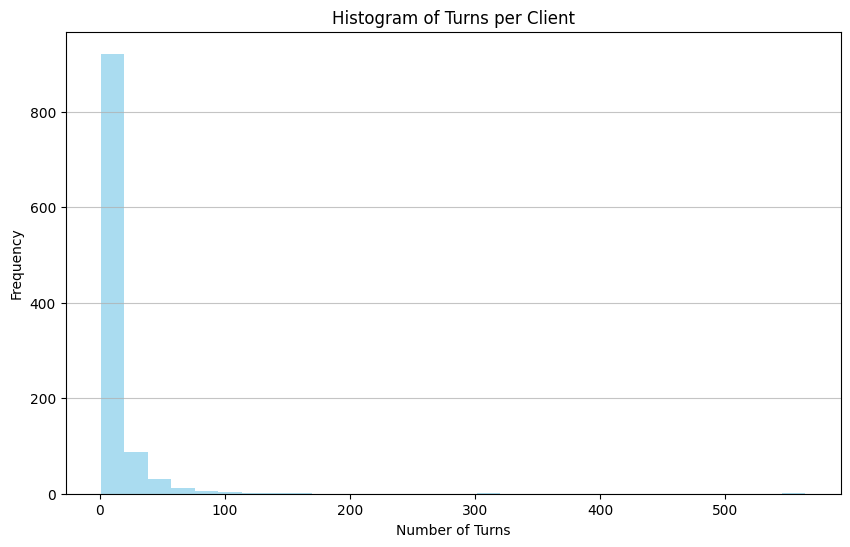

In [13]:
# plot turns per client
plt.figure(figsize=(10, 6))
plt.hist(turns_per_client["turns"], bins=30, color='skyblue', alpha=0.7)
plt.title('Histogram of Turns per Client')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

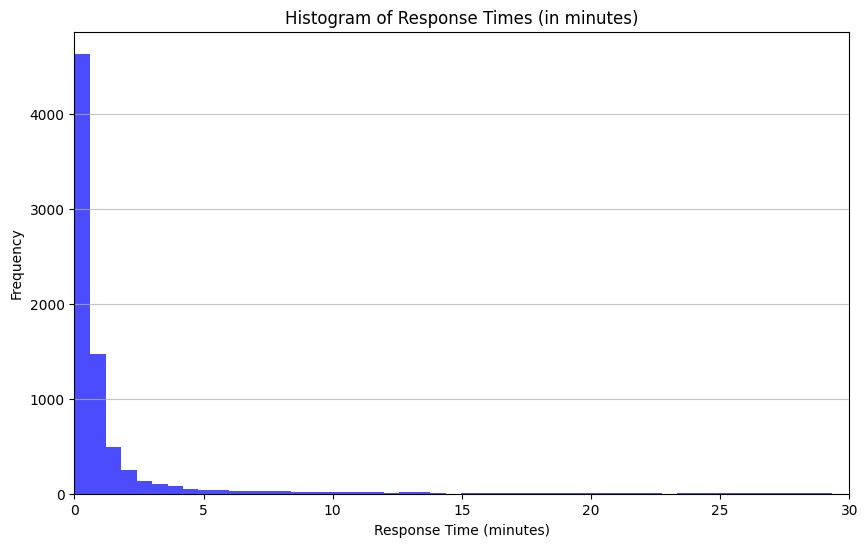

In [11]:
#plot histogram of response times
plt.figure(figsize=(10, 6))
plt.hist(response_times_clean, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Response Times (in minutes)')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, 30)  # limit x-axis to 30 minutes
plt.grid(axis='y', alpha=0.75)
plt.show()